In [1]:
from pylab import *
from brian2 import *
import time

from brian2.units.allunits import henry

%matplotlib inline

plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'text.usetex': True})
plt.rcParams.update({'font.family': 'serif', 
                     'font.serif':['Computer Modern']})


In [2]:
def crvec(N, D=1):
    rphase = 2*np.pi * np.random.rand(D, N)
    return np.cos(rphase) + 1.0j * np.sin(rphase)


In [3]:
def norm_range(v):
    return (v-v.min())/(v.max()-v.min())

In [4]:
def activation_thresh(x, sigma=0.0, c_thresh=None):
    
    if c_thresh is None:
        N = x.shape[0]
        c_thresh = 2.0 / N**0.5
        
    xn = np.abs(x)
    
    a = (x ) / (np.abs(x) + 1e-12)
    a[xn < c_thresh] = 0
    
    return a

In [5]:
def cviz_im(cvec):
    ss = int(len(cvec)**0.5)
    
    ss_idx = ss**2
    
    im_cvec = np.zeros((ss, ss,3))
#     im_cvec[:,:,3]=1
    c=0
    for i in range(ss):
        for j in range(ss):
            if np.abs(cvec[c]) > 0.05:
                im_cvec[i,j,:] = matplotlib.colors.hsv_to_rgb([(np.angle(cvec[c])/2/pi + 1) % 1, 1, 1])
                
            c+=1
                
    return im_cvec
    

In [6]:
def phase2spikes(cv, freq=5.0):
    st = np.angle(cv) / (2*pi*freq)
    return st

# Threshold Phasor Associative Memory



## Store random sparse phasor patterns in the network

In [7]:
N=25**2
D=201
Ks=25

letter_vectors_c = crvec(N, D)

for d in range(D):
    ip = np.random.choice(N, size=(N-Ks), replace=False)
    letter_vectors_c[d, ip] = 0
    
letter_vectors = 2 * (np.random.randn(D,N) < 0) - 1


In [8]:
J_c = np.dot(letter_vectors_c.T, np.conj(letter_vectors_c))
np.fill_diagonal(J_c, 0)

## Network dynamics and simulations

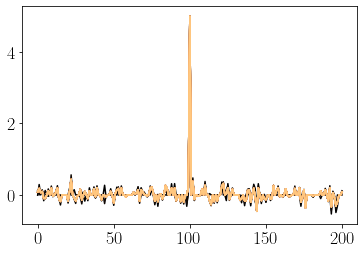

In [9]:
max_steps = 20
hop_hist = np.zeros((D, max_steps+1))
hop_s_hist = np.zeros((N, max_steps+1), 'complex')

target_idx = 100

hop_state_i = letter_vectors_c[target_idx,:].copy()
hop_state_i[:300] = 0

noise_state = 0.0 * np.random.randn(N) * np.squeeze(crvec(N,1)) #2*(np.random.randn(N) < 0) - 1
hop_state = hop_state_i + noise_state

hop_state /= norm(hop_state)

cols = get_cmap('copper', max_steps)

c_thresh = 0.6/Ks**0.5
for i in range(max_steps):
    hop_hist[:,i] = np.real(np.dot(np.conj(letter_vectors_c), hop_state))    
    hop_s_hist[:,i] = hop_state
    
    hop_u = np.dot(J_c, hop_state) / Ks
    hop_state = activation_thresh(hop_u, c_thresh=c_thresh )
    hop_state /= norm(hop_state)

    plot(hop_hist[:,i], c=cols(i))

hop_hist[:,i+1] =  np.real(np.dot(np.conj(letter_vectors_c), hop_state))
plot(hop_hist[:,i], c=cols(i))

Text(0.5, 1.0, 'Target')

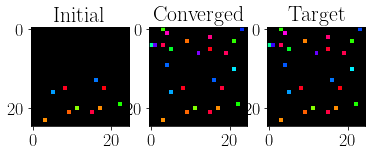

In [10]:
figure(figsize=(6,3))

subplot(131)
imshow(cviz_im(hop_state_i))
title('Initial')
subplot(132)
imshow(cviz_im(hop_s_hist[:, -2]))
title('Converged')
subplot(133)
imshow(cviz_im(letter_vectors_c[target_idx,:]))
title('Target')

## Resonate-and-fire TPAM

This implements the TPAM with resonate-and-fire neurons and complex impulse synapses. However, this implementation does not have dynamic feedback thresholding.

In [11]:
N_vec = 500
N_inh_ff = 5
N_out = 60

pvecs = crvec(N_vec, N_out).T
Ks = int(0.05 * N_vec)

for d in range(N_out):
    ip = np.random.choice(N_vec, size=(N_vec-Ks), replace=False)
    pvecs[ip, d] = 0
    
pmat = np.dot(pvecs, np.conj(pvecs.T)) / Ks

np.fill_diagonal(pmat, 0)

In [12]:
ll = 1
omega = 10 * Hz
alpha = 0.1

eqs2 = Equations('''
    du/dt = ll * u - omega * v : 1
    dv/dt = omega * u + ll * v : 1
''')


In [13]:
# Neuron parameters
C_Sh = 4 * nF # Capacitance
L_Sh = 10e-3/1e-9  * henry # Inductance

g_l = 30.0 * nS # leak conductance
E_l = -60.0 * mV # Resting potential

V_t = -58.0 * mV # Threshold


eqs_2_h = Equations('''
    dVs/dt = (g_l * (E_l - Vs) - 2*pi*Us + I_ext) / C_Sh : volt
    dUs/dt = -2*pi*(E_l - Vs) / L_Sh : amp
    I_ext : amp
    ''')

s_h = '''
mag_v : 1
mag_u : 1
'''
s_h_on_pre = '''
Vs_post += mag_v * mV
Us_post += mag_u * nA
'''

In [14]:
cycle_freq = 1/(np.sqrt(L_Sh * C_Sh))
VU_factor = sqrt(C_Sh/L_Sh) * mV/nA

print(cycle_freq)

5. Hz


In [15]:
nreps = 1

target_idx = 22

init_vector = pvecs[:, target_idx].copy()

init_vector[200:] = 0
keep_idx = np.abs(init_vector) > 0.5

stt = phase2spikes(init_vector)*second  +0.11*second
#spike_indices = np.zeros_like(stt)
spike_indices = np.arange(stt.shape[0])

#keep_idx = np.random.rand(stt.shape[0]) < 1
stt = stt[keep_idx]
spike_indices = spike_indices[keep_idx]

spike_times = np.tile(stt, (nreps))
spike_indices = np.tile(spike_indices, (nreps))

for i in range(nreps):
    spike_times[(i*N_vec):((i+1)*N_vec)] = spike_times[:N_vec] + i * 200*ms

In [16]:

G_pre = SpikeGeneratorGroup(N_vec, spike_indices, spike_times)
G_post = NeuronGroup(N_vec, model=eqs_2_h, threshold='Vs>V_t and Us>0*nA',  
                     refractory=120*ms, method='euler')

G_post.Vs = (E_l + 0.0*mV) * ones(N_vec)
G_post.Us = 0.0 * VU_factor * nA * ones(N_vec)
G_post.I_ext = 0

S_pre_post = Synapses(G_pre, G_post, s_h, on_pre=s_h_on_pre, method='euler')
S_recurrent = Synapses(G_post, G_post, s_h, on_pre=s_h_on_pre, method='euler')

# Input connections
S_pre_post.connect(j='i')
S_pre_post.mag_u = -0.1 * VU_factor
S_pre_post.mag_v = 3

# Recurrent connections
syn_thresh = 0.1 / (2*N_vec) ** 0.5
synidxs = np.where(np.abs(pmat.T) > syn_thresh)
S_recurrent.connect(i=synidxs[0], j=synidxs[1])

syn_idxs_f = np.where(np.abs(pmat.T).flatten() > syn_thresh)[0]
syn_abs = np.abs(pmat.T).flatten()
syn_phase = -1*np.angle(pmat.T).flatten()

syn_g = 5.0
S_recurrent.mag_v = syn_g * syn_abs[syn_idxs_f] * np.cos(syn_phase[syn_idxs_f])
S_recurrent.mag_u = syn_g * syn_abs[syn_idxs_f] * VU_factor * np.sin(syn_phase[syn_idxs_f])

# Monitors
SpM_post = SpikeMonitor(G_post)
StM_post = StateMonitor(G_post, True, record=True)


WARNING    Removing unsupported flag '-march=native' from compiler flags. [brian2.codegen.cpp_prefs]
WARNING    'i' is an internal variable of group 'synapses', but also exists in the run namespace with the value 0. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


In [17]:
complex_net = Network()
complex_net.add(G_pre)
complex_net.add(G_post)

complex_net.add(S_pre_post)
complex_net.add(S_recurrent)

complex_net.add(SpM_post)
complex_net.add(StM_post)

complex_net.store('init')

In [18]:
run_time = 5.0 * second
#complex_net.restore('init')
tst = time.time()
complex_net.run(run_time)
print("elapsed", time.time() - tst)

elapsed 9.009353876113892


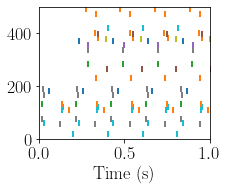

In [19]:
figure(figsize=(3.5,3))

spike_trains_post = SpM_post.spike_trains()

for i in range(N_vec):
    plot(spike_trains_post[i], i * ones(len(spike_trains_post[i])), '|', mew=2)

ylim([0, N_vec])
xlim([0, 1])

xlabel('Time (s)')

plt.tight_layout()

25 == 25


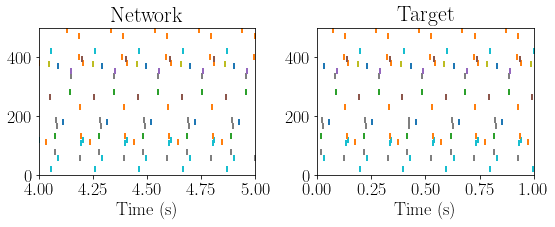

In [20]:
figure(figsize=(8,3.5))

subplot(121)
c=0
for i in range(N_vec):
    plot(spike_trains_post[i], i * ones(len(spike_trains_post[i])), '|', mew=2)
    if len(spike_trains_post[i])>2:
        c+=1
        
print(c, '==', Ks)

xlim([4,5])
ylim([0, N_vec])

xlabel('Time (s)')
title('Network')


target_vector = pvecs[:, target_idx].copy()

stt = phase2spikes(target_vector)*second  +0.11*second
spike_indices = np.arange(stt.shape[0])

keep_idx = np.abs(target_vector) > 0.5
stt = stt[keep_idx]
spike_indices = spike_indices[keep_idx]

nreps = 10
spike_times_target = np.tile(stt, (nreps))
spike_indices_target = np.tile(spike_indices, (nreps))

for i in range(nreps):
    spike_times_target[(np.arange(len(stt)) + i * len(stt))] = spike_times_target[:len(stt)] + i * 200*ms

    
subplot(122)
for i in range(N_vec):
    sp_times = spike_times_target[spike_indices_target==i]
    plot(sp_times, i*np.ones(sp_times.shape) , '|', mew=2)

xlabel('Time (s)')
xlim([0, 1])
ylim([0, N_vec])
title('Target')

plt.tight_layout()


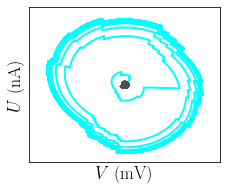

In [21]:
figure(figsize=(3.5,3))

N_ex = spike_indices[0]
ex=2

plot(StM_post.Vs[N_ex]/mV, StM_post.Us[N_ex]/nA, c='cyan', lw=2)
plot(StM_post.Vs[ex]/mV, StM_post.Us[ex]/nA, c=[0.3, 0.3, 0.3], lw=2)

xl_V = 8*mV
xlim([E_l/mV - xl_V/mV, E_l/mV + xl_V/mV])
ylim([- xl_V * VU_factor /mV, xl_V * VU_factor/mV])

xticks([])
yticks([])
xlabel('$V$ (mV)')
ylabel('$U$ (nA)')

plt.tight_layout()

## Biophysical TPAM

In [22]:
# Neuron parameters
C_ex = 0.5 * nF # Capacitance of action-potential compartment
C_in = 0.5 * nF # Capacitance of inhibitory cells

g_l =  4.0 * nS # leak conductance
E_l = -60.0 * mV # Resting potential

V_t = -58.0 * mV # Threshold
V_r = -62.0 * mV # Reset

eqs_1 = Equations('''
    dV/dt = (g_l * (E_l - V) + I_ext + I_rec + I_inh + I_c) / C_ex : volt
    I_ext : amp
    I_rec : amp
    I_inh : amp
    I_c : amp
    ''')
eqs_1_in = Equations('''
    dV/dt = (g_l * (E_l - V) + I_ext + I_rec + I_inh + I_c) / C_in : volt
    I_ext : amp
    I_rec : amp
    I_inh : amp
    I_c : amp
    ''')

s_delay = 0
s_c_freq = (2*np.pi* (5.0)) / second

s_delay_pre = '''
mag : 1
I_ext_post = sx * nA : amp (summed)
dsx/dt = -s_c_freq * sx : 1 (clock-driven)
'''
s_delay_inh = '''
mag : 1
I_inh_post = sx * nA : amp (summed)
dsx/dt = -0.25*s_c_freq * sx : 1 (clock-driven)
'''
s_delay_rec = '''
mag : 1
I_rec_post = sx * nA : amp (summed)
dsx/dt = -s_c_freq * sx : 1 (clock-driven)
'''

s_delay_on_pre = '''
sx += mag
'''

In [23]:
N_vec = 500
N_inh_ff = 5
N_out = 100

In [24]:
pvecs = crvec(N_vec, N_out).T
Ks = int(0.05 * N_vec)

for d in range(N_out):
    ip = np.random.choice(N_vec, size=(N_vec-Ks), replace=False)
    pvecs[ip, d] = 0
    
pmat = np.dot(pvecs, np.conj(pvecs.T)) / Ks

np.fill_diagonal(pmat, 0)

In [25]:
target_idx = 86
init_vector = pvecs[:, target_idx].copy()
#init_vector += pvecs[:, 7] + pvecs[:, 22]
init_vector[200:] = 0

In [26]:
stt = phase2spikes(init_vector)*second  +0.11*second
spike_indices = np.arange(stt.shape[0])

In [27]:
keep_idx = np.abs(init_vector) > 0.5
stt = stt[keep_idx]
spike_indices = spike_indices[keep_idx]

In [28]:
nreps = 1
spike_times = np.tile(stt, (nreps))
spike_indices = np.tile(spike_indices, (nreps))

for i in range(nreps):
    spike_times[(i*N_vec):((i+1)*N_vec)] = spike_times[:N_vec] + i * 200*ms

In [29]:
phase_shift =  np.arctan(g_l/(s_c_freq *  C_ex))
rc_delay = phase_shift/s_c_freq

print('RC delay:', rc_delay)

RC delay: 7.93700478 ms


In [30]:
G_pre = SpikeGeneratorGroup(N_vec, spike_indices, spike_times)
G_post = NeuronGroup(N_vec, model=eqs_1, threshold='V>V_t', reset='V=V_r', refractory=150*ms, method='euler')
G_inh_ff = NeuronGroup(N_inh_ff, model=eqs_1_in, threshold='V>V_t', reset='V=V_r', refractory=0*ms, method='euler')

G_post.V = E_l * ones(N_vec) + 0*mV * np.random.randn(N_vec)
G_post.I_c = 1.0 * pA + 1.0*pA *np.random.randn(N_vec)
G_inh_ff.V = E_l * ones(N_inh_ff) + 0*mV * np.random.randn(N_inh_ff)
G_inh_ff.I_c = 1.0 * pA + 1.0*pA *np.random.randn(N_inh_ff)


S_pre_post = Synapses(G_pre, G_post, s_delay_pre, on_pre=s_delay_on_pre, method='euler')
S_pre_inh_ff = Synapses(G_pre, G_inh_ff, s_delay_pre, on_pre=s_delay_on_pre, method='euler')

S_recurrent = Synapses(G_post, G_post, s_delay_rec, on_pre=s_delay_on_pre, method='euler')
#S_post_inh_ff = Synapses(G_post, G_inh_ff, s_delay_inh, on_pre=s_delay_on_pre, method='euler')
S_post_inh_ff = Synapses(G_post, G_inh_ff, s_delay_rec, on_pre=s_delay_on_pre, method='euler')

S_inh_ff_post = Synapses(G_inh_ff, G_post, s_delay_inh, on_pre=s_delay_on_pre, method='euler')


S_pre_post.connect(j='i')
S_pre_post.mag = 0.3
S_pre_post.delay = 30.0*ms

S_pre_inh_ff.connect()
S_pre_inh_ff.mag = 0.5/Ks
S_pre_inh_ff.delay = 0.0*ms


syn_thresh = 0.1 / (2*N_vec) ** 0.5
synidxs = np.where(np.abs(pmat.T) > syn_thresh)
S_recurrent.connect(i=synidxs[0], j=synidxs[1])

syn_idxs_f = np.where(np.abs(pmat.T).flatten() > syn_thresh)[0]
syn_abs = np.abs(pmat.T).flatten()
syn_phase = np.angle(pmat.T).flatten()
S_recurrent.mag = 1.5 * syn_abs[syn_idxs_f]
S_recurrent.delay = syn_phase[syn_idxs_f] / s_c_freq + 2*np.pi/s_c_freq - 1.5*rc_delay


S_post_inh_ff.connect()
S_post_inh_ff.mag = 0.6/Ks
S_post_inh_ff.delay = 2.0*ms


S_inh_ff_post.connect()
S_inh_ff_post.mag = -0.04 / N_inh_ff
S_inh_ff_post.delay = 2.0*ms


SpM_post = SpikeMonitor(G_post)
SpM_inh_ff = SpikeMonitor(G_inh_ff)

StM_post = StateMonitor(G_post, True, record=True)
StM_inh_ff = StateMonitor(G_inh_ff, True, record=True)

WARNING    'i' is an internal variable of group 'synapses_2', but also exists in the run namespace with the value 0. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


In [31]:
complex_net = Network()
complex_net.add(G_pre)
complex_net.add(G_post)
complex_net.add(G_inh_ff)

complex_net.add(S_pre_post)
complex_net.add(S_pre_inh_ff)

complex_net.add(S_inh_ff_post)

complex_net.add(S_recurrent)
complex_net.add(S_post_inh_ff)

complex_net.add(SpM_post)
complex_net.add(SpM_inh_ff)
complex_net.add(StM_post)
complex_net.add(StM_inh_ff)

complex_net.store('init')

In [32]:
run_time = 5.0 * second
complex_net.restore('init')
tst = time.time()
complex_net.run(run_time)
print("elapsed", time.time() - tst)

elapsed 17.035866022109985


204.4 ms


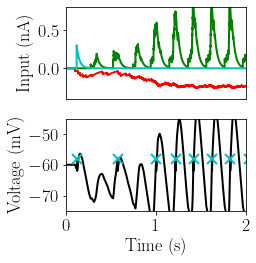

In [33]:
figure(figsize=(4,4))

N_ex = spike_indices[2]

subplot(211)
plot(StM_post.t / second, StM_post.I_rec[N_ex,:]/nA, 'g', lw=2)
plot(StM_post.t / second, StM_post.I_inh[N_ex,:]/nA, 'r', lw=2)
plot(StM_post.t / second, StM_post.I_ext[N_ex,:]/nA, 'c', lw=2)
xticks([])
xlim([0, 2])
ylim([-0.4, 0.8])
ylabel('Input (nA)')

subplot(212)
plot(StM_post.t/ second, StM_post.V[N_ex,:] / mV, 'k', lw=2);
spike_trains_post = SpM_post.spike_trains()
plot(spike_trains_post[N_ex]/second, V_t / mV * ones(len(spike_trains_post[N_ex])), 'cx', lw=2, mew=2, ms=10)

print(np.median(np.diff(spike_trains_post[N_ex])))

xlim([0,2.0])
ylim([-75, -45])
xlabel('Time (s)')
ylabel('Voltage (mV)')

plt.tight_layout()


25 == 25


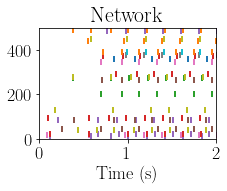

In [34]:
figure(figsize=(3.5,3))

c=0
for i in range(N_vec):
    plot(spike_trains_post[i], i * ones(len(spike_trains_post[i])), '|', mew=2)
    if len(spike_trains_post[i])>2:
        c+=1
        
print(c, '==', Ks)

xlim([0,2])
ylim([0, N_vec])

xlabel('Time (s)')
title('Network')

plt.tight_layout()


25 == 25


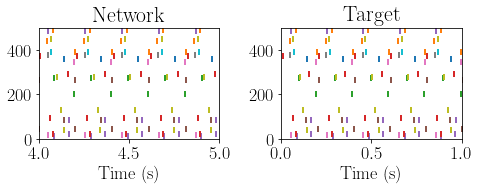

In [35]:
figure(figsize=(7,3))

subplot(121)
c=0
for i in range(N_vec):
    plot(spike_trains_post[i], i * ones(len(spike_trains_post[i])), '|', mew=2)
    if len(spike_trains_post[i])>2:
        c+=1
        
print(c, '==', Ks)

xlim([4,5])
ylim([0, N_vec])

xlabel('Time (s)')
title('Network')


target_vector = pvecs[:, target_idx].copy()

stt = phase2spikes(target_vector)*second  +0.11*second
spike_indices = np.arange(stt.shape[0])

keep_idx = np.abs(target_vector) > 0.5
stt = stt[keep_idx]
spike_indices = spike_indices[keep_idx]

nreps = 10
spike_times_target = np.tile(stt, (nreps))
spike_indices_target = np.tile(spike_indices, (nreps))

for i in range(nreps):
    spike_times_target[(np.arange(len(stt)) + i * len(stt))] = spike_times_target[:len(stt)] + i * 200*ms

    
subplot(122)
for i in range(N_vec):
    sp_times = spike_times_target[spike_indices_target==i]
    plot(sp_times, i*np.ones(sp_times.shape) , '|', mew=2)

xlabel('Time (s)')
xlim([0, 1])
ylim([0, N_vec])
title('Target')

plt.tight_layout()
